In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf

In [51]:
dataset=[]
y=[]
# the number of frames to be included in a sequence
Fs = 10
# change the locattion of the dataset here
root_path = "squats/"

classes = os.listdir(root_path)
print(classes)
for class_name in classes:
    class_path = root_path + "/" + class_name
    files = [class_path + "/" + f for f in os.listdir(class_path) if os.path.isfile(class_path + '/' + f)]
    for file in files:
      df = pd.read_csv(file)
      # remove the face keypoints from the data frame
      df = df.iloc[:,36:]
      # if the models for squats are trained, the keypoints for the arms are removed
      if root_path == "squats/":
        for i in range(14, 24, 1):
          df=df.drop("x"+str(i), axis = "columns")
          df=df.drop("y"+str(i), axis = "columns")
          df=df.drop("z"+str(i), axis = "columns")
          df=df.drop("v"+str(i), axis = "columns")
      for i in range(len(df) - Fs):
          dataset.append(df.iloc[i:i+Fs].to_numpy())
          y.append(class_name)

['back', 'good', 'legs']


In [52]:
len(y)

62626

In [53]:
unique, counts = np.unique(np.array(y), return_counts=True)
dict(zip(unique, counts))

{'back': 18875, 'good': 27958, 'legs': 15793}

In [54]:
y = np.array(y)
dataset = np.asarray(dataset)

In [55]:
dataset.shape

(62626, 10, 56)

In [56]:
from sklearn.preprocessing import LabelEncoder,StandardScaler

encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = tf.keras.utils.to_categorical(y)
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [57]:
encoder.classes_

array(['back', 'good', 'legs'], dtype='<U4')

In [58]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size=0.33, random_state=42)

In [59]:
print(x_train.shape)
print(x_test.shape)
print(x_train[0].shape)

(41959, 10, 56)
(20667, 10, 56)
(10, 56)


Train the model for the shallow CNN architecture and plot the accuracy and loss curves

In [60]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, LSTM, Input, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D

cnn = Sequential()
cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(x_train[0].shape)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(len(classes),activation="softmax"))
cnn.summary()
cnn.compile(optimizer = "adam", loss="categorical_crossentropy", metrics = ['accuracy'])
cnn_hist = cnn.fit(x_train, y_train, epochs = 100, validation_data = (x_test, y_test), verbose = 1, batch_size=32)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 9, 32)             3616      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 4, 32)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 4,003
Trainable params: 4,003
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1312/1312 [==============================] - 3s 2ms/step - loss: 0.8159 - accuracy: 0.6096 - val_loss: 0.6148 - val_accuracy: 0.7307
Epoch 2/100
1312/1312 [==============================] - 3s 2ms/step - loss: 0.6121 - accuracy: 0.7294 - 

1312/1312 [==============================] - 3s 2ms/step - loss: 0.1356 - accuracy: 0.9495 - val_loss: 0.1232 - val_accuracy: 0.9574
Epoch 52/100
1312/1312 [==============================] - 2s 2ms/step - loss: 0.1355 - accuracy: 0.9507 - val_loss: 0.1339 - val_accuracy: 0.9516
Epoch 53/100
1312/1312 [==============================] - 2s 2ms/step - loss: 0.1330 - accuracy: 0.9519 - val_loss: 0.1179 - val_accuracy: 0.9592
Epoch 54/100
1312/1312 [==============================] - 2s 2ms/step - loss: 0.1405 - accuracy: 0.9482 - val_loss: 0.1242 - val_accuracy: 0.9547
Epoch 55/100
1312/1312 [==============================] - 2s 2ms/step - loss: 0.1401 - accuracy: 0.9486 - val_loss: 0.1614 - val_accuracy: 0.9412
Epoch 56/100
1312/1312 [==============================] - 2s 2ms/step - loss: 0.1345 - accuracy: 0.9498 - val_loss: 0.1334 - val_accuracy: 0.9493
Epoch 57/100
1312/1312 [==============================] - 3s 2ms/step - loss: 0.1293 - accuracy: 0.9543 - val_loss: 0.1308 - val_accuracy

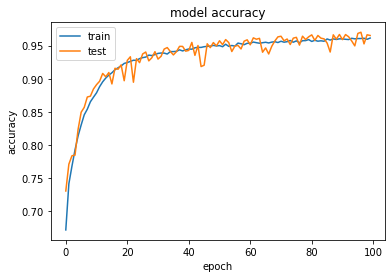

0.9614623785018921
0.965355396270752


In [61]:
import matplotlib.pyplot as plt

plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(cnn_hist.history['accuracy'][-1])
print(cnn_hist.history['val_accuracy'][-1])

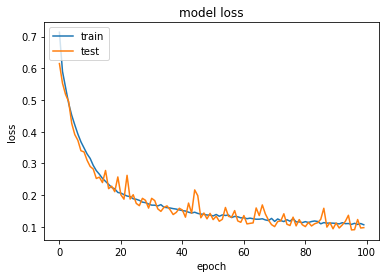

0.10684267431497574
0.0978836789727211


In [62]:
import matplotlib.pyplot as plt

plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(cnn_hist.history['loss'][-1])
print(cnn_hist.history['val_loss'][-1])

Train the model for the deeper CNN architecture and plot the accuracy and loss curves

In [63]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, LSTM, Input, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D

cnn_large = Sequential()
cnn_large.add(Conv1D(filters=512, kernel_size=2, activation='relu', input_shape=(x_train[0].shape)))
cnn_large.add(MaxPooling1D(pool_size=2))
cnn_large.add(Dense(256))
cnn_large.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(x_train[0].shape)))
cnn_large.add(MaxPooling1D(pool_size=2))
cnn_large.add(Flatten())
cnn_large.add(Dense(len(classes),activation="softmax"))
cnn_large.summary()
cnn_large.compile(optimizer = "adam", loss="categorical_crossentropy", metrics = ['accuracy'])

import time

start = time.time()

cnn_large_hist = cnn_large.fit(x_train, y_train, epochs = 100, validation_data = (x_test, y_test), verbose = 1, batch_size=32)

end = time.time()
print(end - start)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 9, 512)            57856     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 4, 512)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 4, 256)            131328    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3, 128)            65664     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

1312/1312 [==============================] - 6s 4ms/step - loss: 0.0491 - accuracy: 0.9826 - val_loss: 0.0513 - val_accuracy: 0.9814
Epoch 49/100
1312/1312 [==============================] - 6s 4ms/step - loss: 0.0420 - accuracy: 0.9853 - val_loss: 0.0946 - val_accuracy: 0.9720
Epoch 50/100
1312/1312 [==============================] - 6s 4ms/step - loss: 0.0455 - accuracy: 0.9842 - val_loss: 0.1698 - val_accuracy: 0.9356
Epoch 51/100
1312/1312 [==============================] - 6s 4ms/step - loss: 0.1016 - accuracy: 0.9709 - val_loss: 0.0788 - val_accuracy: 0.9724
Epoch 52/100
1312/1312 [==============================] - 6s 4ms/step - loss: 0.0390 - accuracy: 0.9873 - val_loss: 0.0391 - val_accuracy: 0.9862
Epoch 53/100
1312/1312 [==============================] - 6s 4ms/step - loss: 0.0512 - accuracy: 0.9839 - val_loss: 0.0329 - val_accuracy: 0.9879
Epoch 54/100
1312/1312 [==============================] - 6s 4ms/step - loss: 0.0378 - accuracy: 0.9865 - val_loss: 0.0302 - val_accuracy

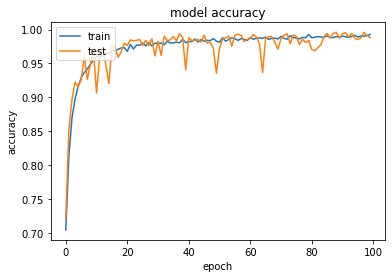

0.9929216504096985
0.9884840846061707


In [64]:
import matplotlib.pyplot as plt

plt.plot(cnn_large_hist.history['accuracy'])
plt.plot(cnn_large_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(cnn_large_hist.history['accuracy'][-1])
print(cnn_large_hist.history['val_accuracy'][-1])

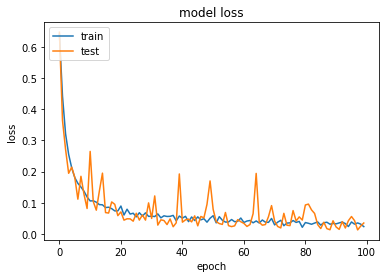

0.02316465973854065
0.034649621695280075


In [65]:
import matplotlib.pyplot as plt

plt.plot(cnn_large_hist.history['loss'])
plt.plot(cnn_large_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(cnn_large_hist.history['loss'][-1])
print(cnn_large_hist.history['val_loss'][-1])

Train the model for the shallow LSTM architecture

In [66]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, LSTM, Input, Dropout
from keras import optimizers


lstm_short = Sequential()

lstm_short.add(LSTM(units = 32, activation = "tanh", input_shape = (x_train[0].shape)))

lstm_short.add(Dense(len(classes), activation = 'softmax'))

lstm_short.summary()

optimizer = optimizers.Adam(clipvalue=1)

lstm_short.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics = ['accuracy'])

import time

start = time.time()

lstm_short_hist = lstm_short.fit(x_train, y_train, epochs = 50, validation_data = (x_test, y_test), verbose = 1, batch_size=32)

end = time.time()
print(end - start)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                11392     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 99        
Total params: 11,491
Trainable params: 11,491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1312/1312 [==============================] - 9s 5ms/step - loss: 0.7401 - accuracy: 0.6422 - val_loss: 0.5685 - val_accuracy: 0.7525
Epoch 2/50
1312/1312 [==============================] - 6s 5ms/step - loss: 0.4759 - accuracy: 0.8010 - val_loss: 0.3474 - val_accuracy: 0.8671
Epoch 3/50
1312/1312 [==============================] - 6s 4ms/step - loss: 0.3493 - accuracy: 0.8639 - val_loss: 0.2959 - val_accuracy: 0.8800
Epoch 4/50
1312/1312 [==============================] - 6s 4ms/step - loss: 0.28

Train the model for the deeper LSTM architecture

In [67]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, LSTM, Input, Dropout

lstm_long = Sequential()

lstm_long.add(LSTM(units = 64, activation = "tanh", return_sequences = True, input_shape = (x_train[0].shape)))

lstm_long.add(Dropout(0.1))

lstm_long.add(LSTM(units= 32, activation = "tanh"))

lstm_long.add(Dense(len(classes), activation = 'softmax'))

lstm_long.summary()

lstm_long.compile(optimizer = "adam", loss="categorical_crossentropy", metrics = ['accuracy'])

import time

start = time.time()

lstm_long_hist = lstm_long.fit(x_train, y_train, epochs = 50, validation_data = (x_test, y_test), verbose = 1, batch_size=32)

end = time.time()
print(end - start)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            30976     
_________________________________________________________________
dropout (Dropout)            (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 99        
Total params: 43,491
Trainable params: 43,491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1312/1312 [==============================] - 21s 13ms/step - loss: 0.7023 - accuracy: 0.6689 - val_loss: 0.4429 - val_accuracy: 0.8198
Epoch 2/50
1312/1312 [==============================] - 16s 12ms/step - loss: 0.4013 - accuracy: 0.835

725.7952916622162


Train the model for the CNN + LSTM architecture

In [68]:
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D, TimeDistributed
from keras.models import Model

input_layer = Input(shape=(x_train[0].shape))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
lstm1 = LSTM(32)(pool1)
output_layer = Dense(len(classes), activation='softmax')(lstm1)
cnn_lstm = Model(inputs=input_layer, outputs=output_layer)
cnn_lstm.summary()

cnn_lstm.compile(optimizer = "adam", loss="categorical_crossentropy", metrics = ['accuracy'])

import time

start = time.time()

cnn_lstm_hist = cnn_lstm.fit(x_train, y_train, epochs = 100, validation_data = (x_test, y_test), verbose = 1, batch_size=32)

end = time.time()
print(end - start)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 56)]          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3, 32)             14368     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 22,787
Trainable params: 22,787
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1312/1312 [==============================] - 8s 4ms/step - loss: 0.8087 - accuracy: 0.6040 - val_loss: 0.6148 -

1312/1312 [==============================] - 4s 3ms/step - loss: 0.0560 - accuracy: 0.9798 - val_loss: 0.0462 - val_accuracy: 0.9839
Epoch 51/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.0556 - accuracy: 0.9806 - val_loss: 0.0475 - val_accuracy: 0.9836
Epoch 52/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.0519 - accuracy: 0.9821 - val_loss: 0.0779 - val_accuracy: 0.9717
Epoch 53/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.0556 - accuracy: 0.9796 - val_loss: 0.0743 - val_accuracy: 0.9733
Epoch 54/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.0545 - accuracy: 0.9817 - val_loss: 0.0397 - val_accuracy: 0.9871
Epoch 55/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.0493 - accuracy: 0.9822 - val_loss: 0.0596 - val_accuracy: 0.9799
Epoch 56/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.0539 - accuracy: 0.9809 - val_loss: 0.0525 - val_accuracy

In [ ]:
The rest of the plots

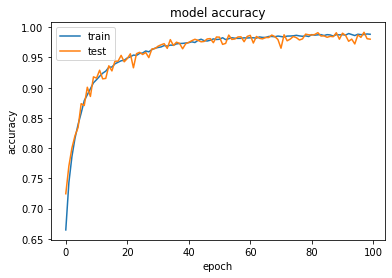

0.9884172677993774
0.9803067445755005


In [69]:
import matplotlib.pyplot as plt

plt.plot(cnn_lstm_hist.history['accuracy'])
plt.plot(cnn_lstm_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(cnn_lstm_hist.history['accuracy'][-1])
print(cnn_lstm_hist.history['val_accuracy'][-1])

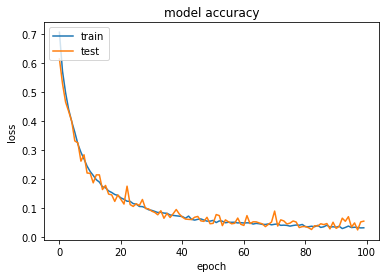

0.03219687566161156
0.05509389936923981


In [70]:
import matplotlib.pyplot as plt

plt.plot(cnn_lstm_hist.history['loss'])
plt.plot(cnn_lstm_hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(cnn_lstm_hist.history['loss'][-1])
print(cnn_lstm_hist.history['val_loss'][-1])

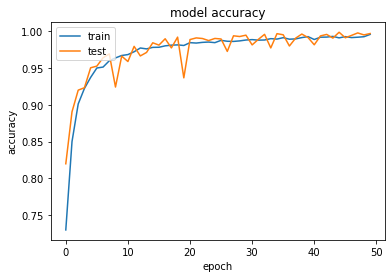

0.9955194592475891
0.9967097043991089


In [71]:
import matplotlib.pyplot as plt

plt.plot(lstm_long_hist.history['accuracy'])
plt.plot(lstm_long_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(lstm_long_hist.history['accuracy'][-1])
print(lstm_long_hist.history['val_accuracy'][-1])

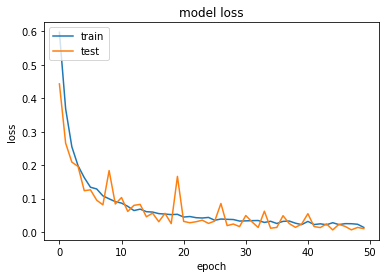

0.014097422361373901
0.010456753894686699


In [72]:
import matplotlib.pyplot as plt

plt.plot(lstm_long_hist.history['loss'])
plt.plot(lstm_long_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(lstm_long_hist.history['loss'][-1])
print(lstm_long_hist.history['val_loss'][-1])

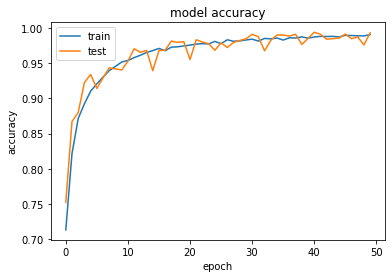

0.9902523756027222
0.9928871989250183


In [73]:
import matplotlib.pyplot as plt

plt.plot(lstm_short_hist.history['accuracy'])
plt.plot(lstm_short_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(lstm_short_hist.history['accuracy'][-1])
print(lstm_short_hist.history['val_accuracy'][-1])

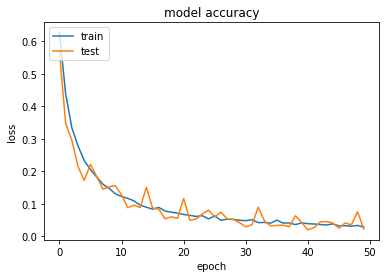

0.028203431516885757
0.022289982065558434


In [74]:
import matplotlib.pyplot as plt

plt.plot(lstm_short_hist.history['loss'])
plt.plot(lstm_short_hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(lstm_short_hist.history['loss'][-1])
print(lstm_short_hist.history['val_loss'][-1])

Save the models in h5 files

In [75]:
cnn.save("models/squat/squat_cnn_short.h5")

In [76]:
cnn_large.save("models/squat/squat_cnn_large.h5")

In [77]:
lstm_short.save("models/squat/squat_lstm_short.h5")

In [78]:
lstm_long.save("models/squat/squat_lstm_long.h5")

In [79]:
cnn_lstm.save("models/squat/squat_cnn_lstm.h5")

Latency test

In [95]:
samples = x_train[:100]

import datetime

new_samples=[]
for s in samples:
    new_samples.append(s.reshape(1,10,56))

start_time = datetime.datetime.now()

for sample in new_samples:
    lstm_long.predict(sample)

end_time = datetime.datetime.now()

time_diff = (end_time - start_time)


print(time_diff.total_seconds() * 1000 / 100)
print(start)


49.25279
1623768786.9021745
